<a href="https://colab.research.google.com/github/MarioAvolio/proj-data-an/blob/main/Amazon_Food_Text_Classification_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *So, in the spirit of Optimus Prime, let’s dive in, "transform, and roll out!"* 🤖

**Mario Avolio: 880995 - https://marioavolio.netlify.app/**

Credits: 
- https://www.oreilly.com/library/view/natural-language-processing/9781098136789/




# Data

In [45]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [46]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [47]:
PATH_PROJ = "/content/drive/MyDrive/data-proj/"
# if not os.path.exists(PATH_PROJ):
#   PATH_PROJ = "/content/drive/MyDrive/shared/data-proj/"

PATH_PREPROCESSED_DATASET = PATH_PROJ+"preprocessed.csv"

In [48]:
df = pd.read_csv(PATH_PREPROCESSED_DATASET).sample(frac=0.2).reset_index(drop=True) # sampling a fraction of 20% to speed process
df

,text,score
0,1. All natural. Nothing artificial in 'em. No ...,5.0
1,I love this TEA. It has a very smooth taste an...,4.0
2,The chips come in a large box with individuall...,4.0
3,I bought this along with the regular dark roas...,3.0
4,This is undoubtedky one if the best products I...,5.0
...,...,...
7029,IT SAYS ON THE BOX EACH DRINK CONTAINS,5.0
7030,"My baby boy loves eating this food, better tha...",5.0
7031,My husband has been looking for this product i...,5.0
7032,"GREAT LITTLE DRINK,NICE FLAVOR. WILL PROBABLY ...",5.0


## Split

In [49]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [50]:
train, validation = train_test_split(train, test_size=0.2)

In [51]:
train = train.reset_index(drop=True)
train

,text,score
0,Diamond glazed walnut's recipe is similar to E...,5.0
1,She thinks he's getting a treat. My vet sells ...,4.0
2,Wonderful smooth taste. I love this brand. G...,5.0
3,My teenage daughter and all of her friends kee...,5.0
4,FIRST THOUGHTS,4.0
...,...,...
4496,"Great if you are cutting back on fat, they do ...",4.0
4497,I have been a strictly Bigelow earl grey drink...,5.0
4498,These chips are the hottest I have ever tried ...,5.0
4499,I love the RiceSelect blends. I have tried fo...,5.0


In [52]:
validation = validation.reset_index(drop=True)
validation

,text,score
0,This makes a nice robust cup of coffee without...,5.0
1,I first drank this tea on a trip to England la...,5.0
2,I'm a big fan of the Lavazza Dek decaf espress...,5.0
3,"This cocoa is very good. I love it, so does my...",5.0
4,I have a pit mix and a 15 month old lab and bo...,5.0
...,...,...
1121,I have an interesting relationship with Skittl...,5.0
1122,I did not know anything about chutney until I ...,1.0
1123,"Although a little pricey, these are a great wa...",5.0
1124,"I wasn't a soba fan before, but when I tried t...",5.0


In [53]:
test = test.reset_index(drop=True)
test

,text,score
0,I give each of my three dogs one a day and the...,5.0
1,Not a good flavor overall. I have only tried t...,3.0
2,These filters are an inexpensive alternative t...,4.0
3,These are the best potato chips I've ever tast...,5.0
4,My two Siberian cats refused almost a dozen ca...,5.0
...,...,...
1402,These Cet Hextra Premium chews are the best th...,5.0
1403,My family loves this cheese salt and its very ...,5.0
1404,I was really surprised at the taste of the Swi...,5.0
1405,"We got Mexican Nesquik because it was cheaper,...",5.0


In [54]:
!pip install datasets # https://github.com/huggingface/datasets

from datasets import Dataset

train = Dataset.from_pandas(train)
train

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Dataset({
    features: ['text', 'score'],
    num_rows: 4501
})

In [55]:
validation = Dataset.from_pandas(validation)
validation

Dataset({
    features: ['text', 'score'],
    num_rows: 1126
})

In [56]:
test = Dataset.from_pandas(test)
test

Dataset({
    features: ['text', 'score'],
    num_rows: 1407
})

## Looking at the Class Distribution


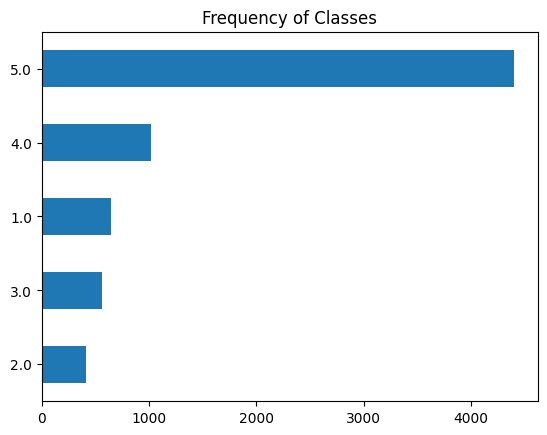

In [57]:
import matplotlib.pyplot as plt
df["score"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; There are several ways to deal with imbalanced data, including:
- Randomly oversample the minority class.
- Randomly undersample the majority class.
- Gather more labeled data from the underrepresented classes.

## How Long Are Our Review?
Transformer models have a maximum input sequence length that is referred to as the
maximum context size. For applications using DistilBERT, the maximum context size
is 512 tokens, which amounts to a few paragraphs of text. 

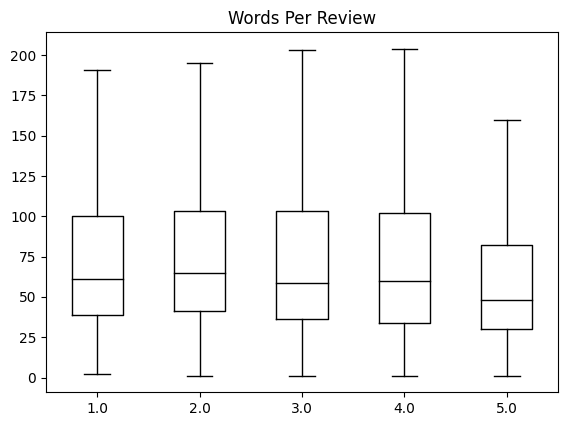

In [58]:
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="score", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 60 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

Map target label to String
1. VERY NEGATIVE
2. NEGATIVE
3. NEUTRAL
4. POSITIVE
5. EXCELLENT


# First form of classification

Transformers has a layered API that allows you to
interact with the library at various levels of abstraction. In this chapter we’ll start with
pipelines, which abstract away all the steps needed to convert raw text into a set of
predictions from a fine-tuned model.

In [59]:
!pip install transformers
from transformers import pipeline
classifier = pipeline("text-classification") 
# . By default, the text-classification pipeline uses a model
# that’s designed for sentiment analysis, but it also supports multiclass and multilabel classification.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Now that we have our pipeline, let’s generate some predictions! Each pipeline takes a
string of text (or a list of strings) as input and returns a list of predictions. Each pre‐
diction is a Python dictionary, so we can use Pandas to display them nicely as a
DataFrame:

In [60]:
import pandas as pd
print(df.text.iloc[0])
outputs = classifier(df.text.iloc[0])
pd.DataFrame(outputs)

1. All natural. Nothing artificial in 'em. No artificial colors or flavors 2. Low calories for a lot o' chips 3. Uber addictive taste-wise  What more needs to be said? I'll be the first to admit, in spite of my being a weight loss coach in the evenings; I am not a big fan of diet food. I am a foodie. I love good food love to cook it, love to eat it. Yet these, to me, are totally addictive. No fake diet food taste, tons of flavor. In fact, I HAVE to get them in the small bags or I will eat a whole large bag it's one of those. Hickory, salty, hint of sweetness.  They aren't fried or fake baked to taste fried.  They use a pressure cooker and the potatoes pop into a chip according to the bag.  I got the automatic shipment of them from Amazon because it reduces the price by 15%and if I get 2 per month it allows for free shipping and, with the no tax, I can't get them in the stores that cheap and they are delivered automatically to my door this way.  Also, these have a lot less salt than the

,label,score
0,POSITIVE,0.614138


# From Text to Token

## Subword Tokenization

In [61]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [62]:
encoded_text = tokenizer(train["text"][0])
print(encoded_text)

{'input_ids': [101, 6323, 19724, 18489, 1005, 1055, 17974, 2003, 2714, 2000, 14110, 1005, 1055, 19724, 18489, 2015, 1998, 16958, 2074, 2004, 2204, 1012, 6323, 18489, 2015, 3465, 2625, 2566, 9044, 2084, 14110, 18489, 2015, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can observe three things here. First, some special [CLS] and [SEP] tokens have
been added to the start and end of the sequence. These tokens differ from model to
model, but their main role is to indicate the start and end of a sequence. Second, the
tokens have each been lowercased, which is a feature of this particular checkpoint.

Finally, we can see that some words have been split into two tokens,
which makes sense since they are not common words. In particular The ## prefix means that the preceding string is not whitespace; any token with this prefix
should be merged with the previous token when you convert the tokens back to a
string. 

In [63]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'diamond', 'glazed', 'walnut', "'", 's', 'recipe', 'is', 'similar', 'to', 'emerald', "'", 's', 'glazed', 'walnut', '##s', 'and', 'tastes', 'just', 'as', 'good', '.', 'diamond', 'walnut', '##s', 'cost', 'less', 'per', 'pound', 'than', 'emerald', 'walnut', '##s', '.', '[SEP]']


In [64]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] diamond glazed walnut ' s recipe is similar to emerald ' s glazed walnuts and tastes just as good. diamond walnuts cost less per pound than emerald walnuts. [SEP]


The AutoTokenizer class also has several attributes that provide information about
the tokenizer. For example, we can inspect the vocabulary size:

In [65]:
tokenizer.vocab_size

30522

and the corresponding model’s maximum context size:


In [66]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model
expects in its forward pass:

In [67]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing the Whole Dataset
To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [68]:
def tokenize(batch):
  '''
  This function applies the tokenizer to a batch of examples; padding=True will pad the
  examples with zeros to the size of the longest one in a batch, and truncation=True
  will truncate the examples to the model’s maximum context size.
  '''
  return tokenizer(batch["text"], padding=True, truncation=True)

In [69]:
encoded_text = tokenize(train[:2])
encoded_text

{'input_ids': [[101, 6323, 19724, 18489, 1005, 1055, 17974, 2003, 2714, 2000, 14110, 1005, 1055, 19724, 18489, 2015, 1998, 16958, 2074, 2004, 2204, 1012, 6323, 18489, 2015, 3465, 2625, 2566, 9044, 2084, 14110, 18489, 2015, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2016, 6732, 2002, 1005, 1055, 2893, 1037, 7438, 1012, 2026, 29525, 15187, 2068, 2005, 2062, 2084, 3313, 2054, 9733, 5571, 2005, 1996, 6635, 2168, 4031, 1012, 2027, 2024, 1037, 2146, 9879, 21271, 2002, 1005, 1055, 2025, 2736, 2007, 2068, 2074, 1999, 1037, 2261, 2847, 1012, 2062, 2066, 1037, 2261, 2420, 1012, 2027, 2079, 2025, 5437, 1998, 2024, 2025, 18307, 1012, 2079, 2027, 2147, 1029, 1045, 2572, 3492, 2469, 2016, 2038, 2488, 3052, 2084, 2077, 2016, 2165, 2068, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

the first element of input_ids is longer than
the second, so zeros have been added to that element to make them the same length.
These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

In [70]:
tokenizer.convert_ids_to_tokens(encoded_text.input_ids[1])

['[CLS]',
 'she',
 'thinks',
 'he',
 "'",
 's',
 'getting',
 'a',
 'treat',
 '.',
 'my',
 'vet',
 'sells',
 'them',
 'for',
 'more',
 'than',
 'double',
 'what',
 'amazon',
 'charges',
 'for',
 'the',
 'exact',
 'same',
 'product',
 '.',
 'they',
 'are',
 'a',
 'long',
 'lasting',
 'chew',
 'he',
 "'",
 's',
 'not',
 'finished',
 'with',
 'them',
 'just',
 'in',
 'a',
 'few',
 'hours',
 '.',
 'more',
 'like',
 'a',
 'few',
 'days',
 '.',
 'they',
 'do',
 'not',
 'smell',
 'and',
 'are',
 'not',
 'messy',
 '.',
 'do',
 'they',
 'work',
 '?',
 'i',
 'am',
 'pretty',
 'sure',
 'she',
 'has',
 'better',
 'breath',
 'than',
 'before',
 'she',
 'took',
 'them',
 '.',
 '[SEP]']

Also note that in addition to returning the encoded tweets as input_ids, the tokenizer returns a list of attention_mask arrays. This is because we do not want the
model to get confused by the additional padding tokens: the attention mask allows
the model to ignore the padded parts of the input.

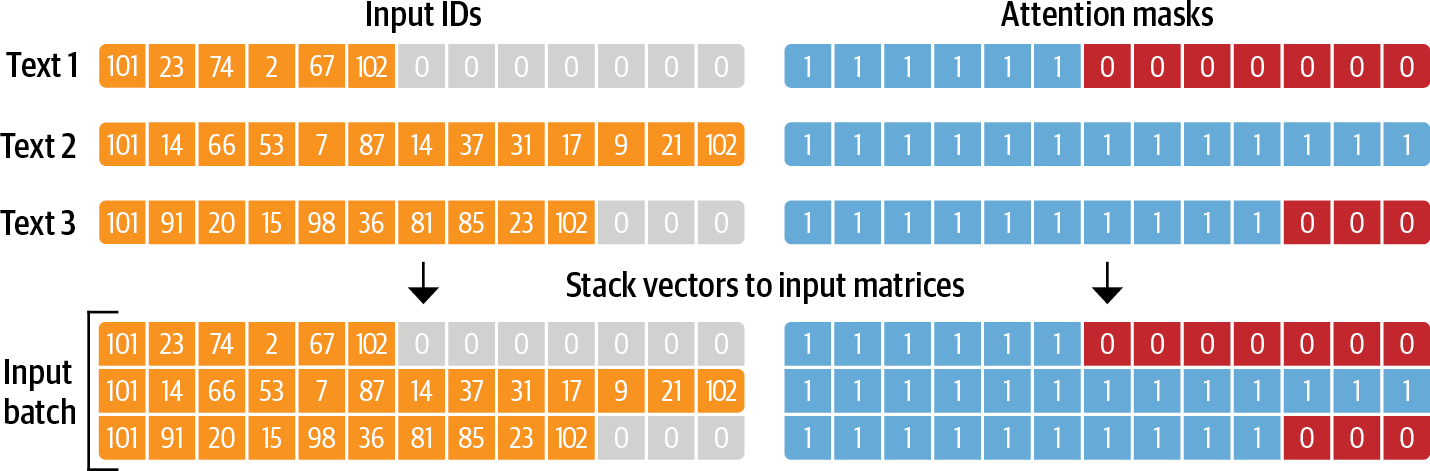

Once we’ve defined a processing function, we can apply it across all the splits in the
corpus in a single line of code:

In [71]:
train = train.map(tokenize, batched=True, batch_size=None)
validation = validation.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/4501 [00:00<?, ? examples/s]

Map:   0%|          | 0/1126 [00:00<?, ? examples/s]

By default, the map() method operates individually on every example in the corpus,
so setting batched=True will encode the tweets in batches. Because we’ve set
batch_size=None, our tokenize() function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally, and we can see that this operation has added new input_ids and
attention_mask columns to the dataset

In [72]:
train.column_names

['text', 'score', 'input_ids', 'attention_mask']

# Training a Text Classifier
First, the text is tokenized and represented as one-hot vectors called token encodings.
The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. Next, these token encodings
are converted to token embeddings, which are vectors living in a lower-dimensional
space. The token embeddings are then passed through the encoder block layers to
yield a hidden state for each input token. For the pretraining objective of language
modeling, each hidden state is fed to a layer that predicts the masked input tokens.
For the classification task, we replace the language modeling layer with a classification layer

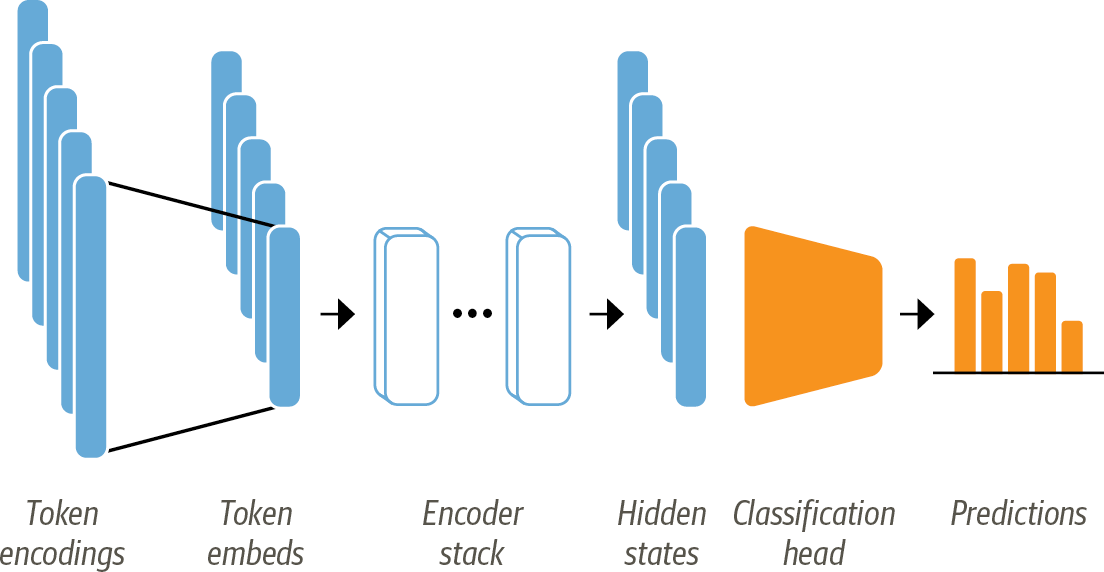

## Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple. Freeze the body’s weights during training and use the hidden states as features for the
classifier. The advantage of this approach is that we can quickly train a small or shallow model.

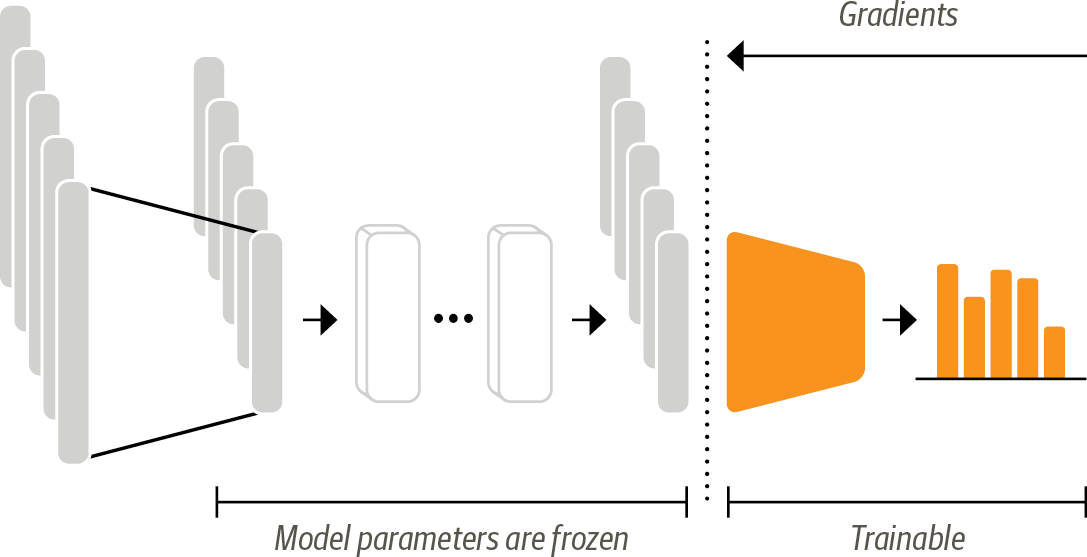

### Using pretrained models


In [73]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The AutoModel class converts the token encodings to embeddings, and then feeds
them through the encoder stack to return the hidden states. Let’s take a look at how
we can extract these states from our corpus.

### Extracting the last hidden states

To warm up, let’s retrieve the last hidden states for a single string. The first thing we
need to do is encode the string and convert the tokens to PyTorch tensors. This can
be done by providing the return_tensors="pt" argument to the tokenizer as follows:

In [74]:
text = train["text"][:1]
print(text)
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
inputs.items()

["Diamond glazed walnut's recipe is similar to Emerald's glazed walnuts and tastes just as good. Diamond walnuts cost less per pound than Emerald walnuts."]
Input tensor shape: torch.Size([1, 35])


dict_items([('input_ids', tensor([[  101,  6323, 19724, 18489,  1005,  1055, 17974,  2003,  2714,  2000,
         14110,  1005,  1055, 19724, 18489,  2015,  1998, 16958,  2074,  2004,
          2204,  1012,  6323, 18489,  2015,  3465,  2625,  2566,  9044,  2084,
         14110, 18489,  2015,  1012,   102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))])

As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that
we have the encodings as a tensor, the final step is to place them on the same device
as the model and pass the inputs as follows

In [75]:
inputs = {k:v.to(device) for k,v in inputs.items()}

# Here we’ve used the torch.no_grad() context manager to disable the automatic calculation of the gradient.
# This is useful for inference since it reduces the memory foot print of the computations. 
with torch.no_grad(): 
  outputs = model(**inputs) # ** pass a variable number keyword arguments (keys and values.)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.3370,  0.0344, -0.0605,  ..., -0.0586,  0.3293,  0.2912],
         [ 0.3652,  0.1767, -0.1297,  ...,  0.1351,  0.6914, -0.2714],
         [ 0.3450,  0.3265, -0.0772,  ...,  0.0300,  0.1995, -0.1777],
         ...,
         [-0.1453,  0.1234, -0.1993,  ...,  0.1696, -0.1857, -0.3599],
         [ 0.4973,  0.1379, -0.3269,  ...,  0.3275, -0.5090, -0.3296],
         [-1.2794,  0.1938,  0.0666,  ..., -0.0781, -0.0928,  0.0049]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [76]:
outputs.last_hidden_state.size()

torch.Size([1, 35, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the input tokens.

For classification tasks, it is common practice to just use
the hidden state associated with the [CLS] token as the input feature. Since this token
appears at the start of each sequence, we can extract it by simply indexing into
outputs.last_hidden_state as follows

In [77]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string; let’s do the same for
the whole dataset by creating a new hidden_state column that stores all these vectors

In [78]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # we place the final hidden state back on the CPU as a NumPy array
  # The map() method requires the processing function to return Python or NumPy objects when
  # we’re using batched inputs.

Since our model expects tensors as inputs, the next thing to do is convert the
input_ids and attention_mask columns to the "torch" format, as follows:

In [79]:
train.set_format("torch", columns=["input_ids", "attention_mask", "score"])
validation.set_format("torch", columns=["input_ids", "attention_mask", "score"])

train, validation

(Dataset({
     features: ['text', 'score', 'input_ids', 'attention_mask'],
     num_rows: 4501
 }),
 Dataset({
     features: ['text', 'score', 'input_ids', 'attention_mask'],
     num_rows: 1126
 }))

We can then go ahead and extract the hidden states across all splits in one go:


In [80]:
train = train.map(extract_hidden_states, batched=True, batch_size=256)

Map:   0%|          | 0/4501 [00:00<?, ? examples/s]

In [81]:
train.column_names

['text', 'score', 'input_ids', 'attention_mask', 'hidden_state']

Now we can execute the same process to the validation set

In [82]:
validation = validation.map(extract_hidden_states, batched=True, batch_size=256)
validation.column_names

Map:   0%|          | 0/1126 [00:00<?, ? examples/s]

['text', 'score', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each review, the next step is to
train a classifier on them. To do that, we’ll need a feature matrix let’s take a look.

### Creating a feature matrix
The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We
can easily create the corresponding arrays in the well-known Scikit-learn format as
follows:


In [83]:
import numpy as np
X_train = np.array(train["hidden_state"])
X_valid = np.array(validation["hidden_state"])
y_train = np.array(train["score"])
y_valid = np.array(validation["score"])
X_train.shape, X_valid.shape

((4501, 768), (1126, 768))

### Visualizing the training set
Before we train a model on the hidden states, it’s good practice to perform a quick
check to ensure that they provide a useful representation of the emotions we want to classify. Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
use the powerful UMAP algorithm to project the vectors down to 2D (https://arxiv.org/abs/1802.03426) . Since UMAP
works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a
MinMaxScaler and then use the UMAP implementation from the umap-learn library
to reduce the hidden states:

In [96]:
!pip uninstall umap
!pip install umap-learn 
# # https://umap-learn.readthedocs.io/en/latest/
# !pip install umap-learn[plot]
# !pip install holoviews
# !pip install -U ipykernel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59421 sha256=33c77d4c8db44917b21c0d9f6d38b68665ae5f16b1ea16969938d2ed95976e58
  Stored in directory: /root/.cache/pip/wheels/35/c6/63/a3c12ecc9fdea10a593271de5c56481b427ad4049b90a176e1
Successfully built datashape
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [100]:
# # https://umap-learn.readthedocs.io/en/latest/

# for any problem you can consult this link https://github.com/lmcinnes/umap/issues/828
import umap.umap_ as umap
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

In [102]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.346914,-2.802152,5.0
1,7.099480,-2.450001,4.0
2,6.771037,-4.911835,5.0
3,7.191119,-0.406044,5.0
4,13.169969,0.035719,4.0


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let’s investigate the compressed data a little
bit further and plot the density of points for each category separately:

In [123]:
 df_emb.query(f"label == {1.0}")

,X,Y,label
6,7.572320,-3.379449,1.0
24,7.367144,-3.532653,1.0
49,8.618763,-3.234330,1.0
50,4.531913,-3.325762,1.0
51,7.731322,-2.473928,1.0
...,...,...,...
4420,7.479895,-3.124884,1.0
4439,4.033464,-1.937964,1.0
4443,7.726305,-3.600572,1.0
4451,8.287314,-2.687903,1.0


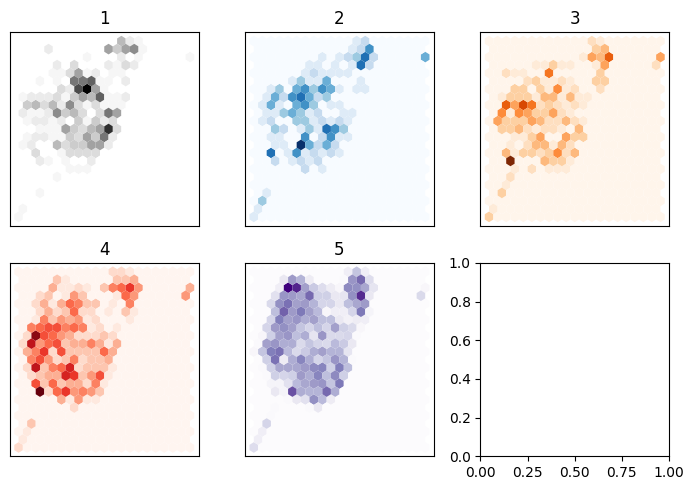

In [126]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]
labels = [1,2,3,4,5] #train.features["score"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {label}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()  
plt.show()